# Lab | API wrappers - Create your collection of songs & audio features

**Instructions**

To move forward with the project, you need to create a collection of songs with their audio features - as large as possible!

These are the songs that we will cluster. And, later, when the user inputs a song, we will find the cluster to which the song belongs and recommend a song from the same cluster. The more songs you have, the more accurate and diverse recommendations you'll be able to give. Although... you might want to make sure the collected songs are "curated" in a certain way. Try to find playlists of songs that are diverse, but also that meet certain standards.

The process of sending hundreds or thousands of requests can take some time - it's normal if you have to wait a few minutes (or, if you're ambitious, even hours) to get all the data you need.

An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!

### 1. Libary imports

In [80]:
import pandas as pd
import numpy as np
import requests
import json
import time
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### 2. Authentification

In [81]:
# Initialize SpotiPy with user credentias

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))


### 3. Playlists fetching
### 3.1. Featured playlists

In [82]:
# get featured playlists from spotify 
# offset not worlking, maybe only 10 playlists availible atm
# inputs: number of playlists, outputs: list of playlist ids, df with playlist names and ids

def get_featured_playlists(n_playlists):
    playlist_names, playlist_ids, sublist_names, sublist_ids = [], [], [], []
    # fetch 10 playlists at a time via api
    for ofs in range(0,n_playlists,10):
        featured_pl_10 = sp.featured_playlists(locale='en_US', country='US', offset=ofs)
        
        # get all playlists of each fetch
        for i in range(len(featured_pl_10['playlists']['items'])):
            sublist_ids.append(featured_pl_10['playlists']['items'][i]['id'])
            sublist_names.append(featured_pl_10['playlists']['items'][i]['name'])
        
        # fill output lists
        playlist_ids += sublist_ids
        playlist_names += sublist_names
        time.sleep(2)
    
    # overview df
    featured_playlists_total = pd.DataFrame({'name': playlist_names, 'ids': playlist_ids})
    return playlist_ids, featured_playlists_total

In [83]:
featured_10_ids, featured_10 = get_featured_playlists(n_playlists=10)


In [84]:
featured_10_ids

['37i9dQZF1DX4JAvHpjipBk',
 '37i9dQZF1DWWBHeXOYZf74',
 '37i9dQZF1DWWvvyNmW9V9a',
 '37i9dQZF1DWVcbzTgVpNRm',
 '37i9dQZF1DX4dyzvuaRJ0n',
 '37i9dQZF1DX82GYcclJ3Ug',
 '37i9dQZF1DX0b1hHYQtJjp',
 '37i9dQZF1DWY4xHQp97fN6',
 '37i9dQZF1DWZQaaqNMbbXa',
 '37i9dQZF1DX8CopunbDxgW',
 '37i9dQZF1DX4SBhb3fqCJd']

### 3.2 User playlists (alternative)

In [85]:
# get playlists from spotify user
# offset not worlking, maybe only 10 playlists availible atm
# inputs: user id, optional: number of playlists, outputs: list of playlist ids, df with playlist names and ids

def get_user_playlists(user_id, n_playlists=-1):
    playlist_names, playlist_ids = [], []
    
    # fetch first 20 playlists 
    results = sp.user_playlists(user=user_id, limit=20)
    user_playlists = results['items']
    time.sleep(2)
    
    # fetch playlist 21 - end
    for ofs in range(20,n_playlists,20):
        results = sp.user_playlists(user=user_id, limit=20, offset=ofs)
        user_playlists += results['items']
        time.sleep(2)
        
    # option to limit the no of playlists retreived
    if n_playlists > 0:
        if n_playlists < results['total']:
            user_playlists = user_playlists[:n_playlists]
        
    # extract name and id
    for pl in user_playlists:
        playlist_ids.append(pl['id'])
        playlist_names.append(pl['name'])
        playlist_ids = playlist_ids[:n_playlists]
        playlist_names = playlist_names[:n_playlists]
        
    # overview df
    user_playlists_total = pd.DataFrame({'name': playlist_names, 'ids': playlist_ids})
    return playlist_ids, user_playlists_total

In [86]:
# get offiacal spotify playlists
# number of playlists, outputs: list of playlist ids, df with playlist names and ids

def get_spotify_playlists(n_playlists):
    spo_playlist_ids, spo_playlists_total = get_user_playlists(user_id='spotify', n_playlists=n_playlists)
    return spo_playlist_ids, spo_playlists_total

In [87]:
spotify_playlist_ids, spotify_playlists_total = get_spotify_playlists(n_playlists=30)

In [88]:
spotify_playlists_total

,name,ids
0,Today's Top Hits,37i9dQZF1DXcBWIGoYBM5M
1,RapCaviar,37i9dQZF1DX0XUsuxWHRQd
2,Hot Country,37i9dQZF1DX1lVhptIYRda
3,¡Viva Latino!,37i9dQZF1DX10zKzsJ2jva
4,New Music Friday,37i9dQZF1DX4JAvHpjipBk
5,Peaceful Piano,37i9dQZF1DX4sWSpwq3LiO
6,Are & Be,37i9dQZF1DX4SBhb3fqCJd
7,Rock Classics,37i9dQZF1DWXRqgorJj26U
8,mint,37i9dQZF1DX4dyzvuaRJ0n
9,Rock This,37i9dQZF1DXcF6B6QPhFDv


### 4. Artists fetching

In [89]:
# fetch all artists present in a playlist
# inputs: playlist id, outputs: list of artist ids

def get_artists_from_playlist(plst_id):
    # get first 100 tracks from playlist
    playlist = sp.playlist_tracks(playlist_id=plst_id)
    tracks = playlist['items']
    artist_ids = []

    # get track 101 - end from playlist
    for ofs in range(100,playlist['total'],100):
        playlist = sp.playlist_tracks(playlist_id=plst_id, offset=ofs)
        time.sleep(2)
        tracks += playlist['items']
    
    # extract artist ids
    for track in tracks:
        for a in track['track']['artists']:
            artist_ids.append(a['id'])
            
    return list(set(artist_ids))


In [90]:
artist_ids = []

for playlist_id in spotify_playlist_ids[11:15]:
    pl_artist_ids = get_artists_from_playlist(plst_id=playlist_id)
    artist_ids += pl_artist_ids


In [91]:
len(artist_ids)

465

### 5. Fetching Tracks from Artists

In [92]:
# pick random items from multiple lists of the same length, pick items at the same positions in each list
# inputs: list of lists, number of items, outputs: random list

def select_random_list_items(lists, n_items):
    if len(lists[0]) > n_items:
        new_lists = []
        items_selected = random.sample(range(0, len(lists[0])-1), n_items)
        for l in lists:
            list_selected = []
            for x in items_selected:
                list_selected.append(l[x])
            l = list_selected
            new_lists.append(l)
    return new_lists

In [93]:
# fetch albums from artists (ToDo: max. 20 per artist)
# inputs: artist id, outputs: list of albums

def get_albums_from_artists(art_id):
    # get first 20 albums from artist
    results = sp.artist_albums(artist_id=art_id, album_type='album', limit=20)
    albums = results['items']
    album_ids, album_names = [], []

    # get album 21 - end from artist
    for ofs in range(20,results['total'],20):
        results = sp.artist_albums(artist_id=art_id, album_type='album', limit=20, offset=ofs)
        albums += results['items']
        time.sleep(3)
    
    # extract album ids
    for idx, album in enumerate(albums):
        if albums[idx]['id'] not in album_ids:
            album_ids.append(album['id'])
            album_names.append(album['name'])
        
    return album_ids

In [94]:
# fetch tracks from artists albums
# inputs: album id, outputs: list of albums

def get_tracks_from_artists_albums(art_id, n_items=-1):
    # lists for tracks fetch and outputs
    tracks, track_ids, track_names, artists = [], [], [], []
    # fetch albums from artists
    artist_albums_list = get_albums_from_artists(art_id=art_id)
    
    for abm_id in artist_albums_list:
        # get first 50 tracks from album
        results = sp.album_tracks(album_id=abm_id, limit=50)
        tracks += results['items']
        time.sleep(2)
        
        # get track 51 - end from album
        for ofs in range(50,results['total'],50):
            results = sp.album_tracks(album_id=abm_id, limit=50, offset=ofs)
            tracks += results['items']
            time.sleep(2)

    # extract track info
    if len(artist_albums_list) > 0:
        for idx, track in enumerate(tracks):
            if tracks[idx]['name'] not in track_names:
                # track id
                track_ids.append(track['id'])
                # track name
                track_names.append(track['name'])
                # track artists
                artist_name = ''
                for a in track['artists']:
                    artist_name += (a['name'] + ', ')
                artist_name.strip().strip(',')
                artists.append(artist_name)
    
    # option to select random number of tracks from each artist
    if n_items > 0:
        if n_items < len(track_ids):
            track_info_lists = [track_ids, track_names, artists]
            track_info_lists_selected = select_random_list_items(lists=track_info_lists, n_items=n_items)
            track_ids = track_info_lists_selected[0]
            track_names = track_info_lists_selected[1]
            artists = track_info_lists_selected[2]
            
    # df overview
    tracklist_overview = pd.DataFrame({'artists': artists, 'track_name': track_names, 'track_id': track_ids})
        
    return track_ids, tracklist_overview

In [95]:
# df to collect track info

many_tracks_overview_1 = pd.DataFrame({'artists': [], 'track_name': [], 'track_id': []})

for arst_id in artist_ids[100:150]:
    track_ids_temp, many_tracks_overview = get_tracks_from_artists_albums(art_id=arst_id, n_items=100)
    many_tracks_overview_1 = many_tracks_overview_1.append(many_tracks_overview)
    
many_tracks_overview_1 = many_tracks_overview_1.reset_index(drop=True)

In [96]:
len(many_tracks_overview_1)

3387

In [97]:
many_tracks_overview_1.head()

,artists,track_name,track_id
0,"Prezioso, Andrea Prezioso, Marvin,",Emergency 911 - Club Mix,5mg37gttwSQqlEFH1oBd0C
1,"Prezioso, Andrea Prezioso, Marvin,",Voices - Club Mix,1nTFH8hss8xeu3kmRS4RaT
2,"Prezioso, Andrea Prezioso, Marvin,",Gimme a Beat,3noRGu8b5gW4oLsFYx0yZf
3,"Prezioso, Andrea Prezioso, Marvin,",Let's Talk About a Man - Extended Version,4kE4dAlRmIJlorZM0nFEMk
4,"Prezioso, Andrea Prezioso, Marvin,",Back to Life - Extended Mix,5JZGWw0tDnTlXBvvdO2nAc


# Lab | Unsupervised learning intro

**Instructions**

It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

Check whether or not the song is in the Billboard Hot 200.
Collect the audio features from the Spotify API.
After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

### 1. Audio features fetching

In [98]:
# adding audio features to an existing dataframe with track ids in a column
# inputs: dataframe, column name of track ids, outputs: dataframe

def track_audio_features_to_df(df, tracks):
    # fetching track features
    results = []
    i = 0
    for track in df[tracks]:
        results.append(sp.audio_features(track))
        i+=1
        # a break every 10 itterations
        if (i % 10) == 0:
            time.sleep(2)
        
    # copy features from list to dict
    song_features = {'danceability': [], 'energy': [], 'key': [], 'loudness': [],
                     'mode': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [],
                     'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [], 'time_signature': []}
    
    for track in results:
        for feat in track[0].keys():
            for f in song_features.keys():
                if f == feat:
                    song_features[f].append(track[0][feat])
                    
    # update dataframe
    df_song_features = pd.DataFrame(song_features)
    df_song_info = pd.concat([df, df_song_features], axis=1)
    return df_song_info
            

In [99]:
many_tracks_info = track_audio_features_to_df(df=many_tracks_overview_1, tracks='track_id')

In [108]:
many_tracks_info.head()

,artists,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,"Prezioso, Andrea Prezioso, Marvin,",Emergency 911 - Club Mix,5mg37gttwSQqlEFH1oBd0C,0.782,0.995,3,-4.925,0,0.0376,0.043400,0.510000,0.2440,0.862,131.999,419010,4
1,"Prezioso, Andrea Prezioso, Marvin,",Voices - Club Mix,1nTFH8hss8xeu3kmRS4RaT,0.750,0.818,4,-8.172,1,0.0381,0.003160,0.000055,0.0611,0.587,132.003,359160,4
2,"Prezioso, Andrea Prezioso, Marvin,",Gimme a Beat,3noRGu8b5gW4oLsFYx0yZf,0.749,0.708,2,-7.754,1,0.0472,0.000985,0.887000,0.3160,0.722,140.004,305000,4
3,"Prezioso, Andrea Prezioso, Marvin,",Let's Talk About a Man - Extended Version,4kE4dAlRmIJlorZM0nFEMk,0.802,0.878,10,-8.241,1,0.0491,0.042700,0.005120,0.0766,0.528,134.998,354093,4
4,"Prezioso, Andrea Prezioso, Marvin,",Back to Life - Extended Mix,5JZGWw0tDnTlXBvvdO2nAc,0.715,0.699,1,-6.694,0,0.0399,0.000862,0.065600,0.0788,0.796,133.005,349960,4


### 2. Clustering

**Preprocessing**

In [100]:
# extracting clustering features from song data

X = many_tracks_info.drop(['artists', 'track_name', 'track_id'], axis=1)

In [101]:
# scaling data

from sklearn.preprocessing import StandardScaler, Normalizer

data_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(data_scaled)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.047460,1.647914,-0.604394,0.517040,-1.155098,-0.616756,-0.589346,2.219400,0.149446,1.595730,0.430781,2.601542,0.151011
1,0.839198,0.736627,-0.330353,-0.376611,0.865727,-0.613600,-0.746787,-0.312565,-0.812711,0.433481,0.430916,1.792825,0.151011
2,0.832690,0.170291,-0.878434,-0.261567,0.865727,-0.556161,-0.755297,4.091271,0.528207,1.004040,0.702051,1.060993,0.151011
3,1.177623,1.045538,1.313889,-0.395601,0.865727,-0.544168,-0.592085,-0.287417,-0.731172,0.184126,0.532410,1.724357,0.151011
4,0.611412,0.123954,-1.152475,0.030170,-1.155098,-0.602239,-0.755778,0.012877,-0.719599,1.316790,0.464872,1.668510,0.151011


**KMeans k parameter tuning**

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [103]:
# inertia and silhouette scores for kmeans k parameter tuning 
# inputs: df with features, minimum k, maximum k
# output: df with inertia values and silhouette scores

def kmeans_k_tuning(df, k_min, k_max):
    #calculating inertia and silhouette scores
    inertia, silhouette = [], []
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, random_state=99)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(df, kmeans.predict(df)))
        
    ine = kmeans_k_tuning_plots(k_min=k_min, k_max=k_max, inertia=inertia, silhouette=silhouette)
    
    # storing results in df
    results = pd.DataFrame({'k': list(range(k_min, k_max)), 'inertia': inertia, 'silhouette_score': silhouette})
    return results
    

In [104]:
# inertia and silhouette score plots for kmeans k parameter tuning 
# inputs: minimum k, maximum k, inertia value list, silhouette score value list
# output: inertia value list

def kmeans_k_tuning_plots(k_min, k_max, inertia, silhouette):
    # inertia plot
    plt.figure(figsize=(16,8))
    plt.plot(range(k_min, k_max), inertia, 'bx-')
    plt.title('inertia for k between ' + str(k_min) + ' and ' + str(k_max))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(k_min, k_max+1, 1.0))
    plt.show()
    
    # silhouette score plot
    plt.figure(figsize=(16,8))
    plt.plot(range(k_min, k_max), silhouette, 'bx-')
    plt.title('silhouette score for k between ' + str(k_min) + ' and ' + str(k_max))
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(k_min, k_max+1, 1.0))
    plt.show()
    
    return inertia

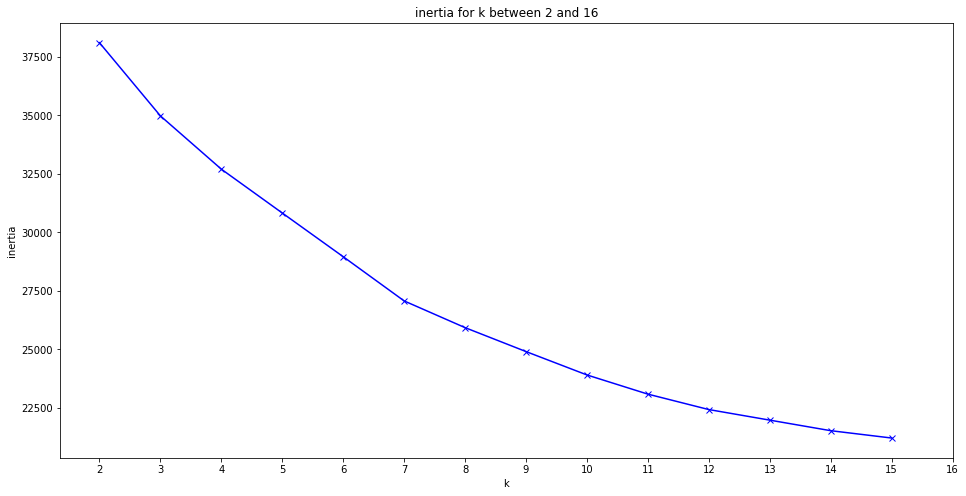

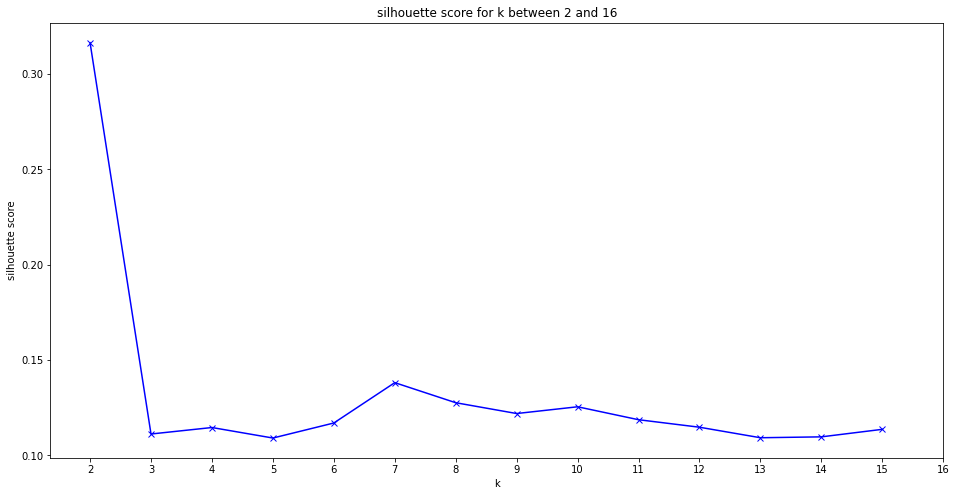

In [105]:
k_scores = kmeans_k_tuning(X_scaled, 2, 16)

In [106]:
k_scores

,k,inertia,silhouette_score
0,2,38101.797661,0.316434
1,3,34976.267170,0.111129
2,4,32700.581304,0.114533
3,5,30827.553357,0.109018
4,6,28960.515464,0.116904
5,7,27071.883653,0.138073
6,8,25930.708099,0.127545
7,9,24908.522447,0.121871
8,10,23909.685781,0.125414
9,11,23090.561447,0.118624


**Clustering**

In [107]:
# KMeans Clustering
kmeans = KMeans(n_clusters=7, random_state=88)
kmeans.fit(X_scaled)

# checking cluster size
clusters = kmeans.predict(X_scaled)
pd.Series(clusters).value_counts().sort_index()


0      93
1    1053
2    1312
3     255
4     169
5     447
6      58
dtype: int64